![alt text](exc13.png "Title")

(a) We measure points. From these, we estimate the mean, and make an empiric CDF. We sample n_observations from the ECDF n_experiment times, and record the number of times it lies in the interval, and weight it by the total number of conducted experiments. That should give us an estimate of p. 


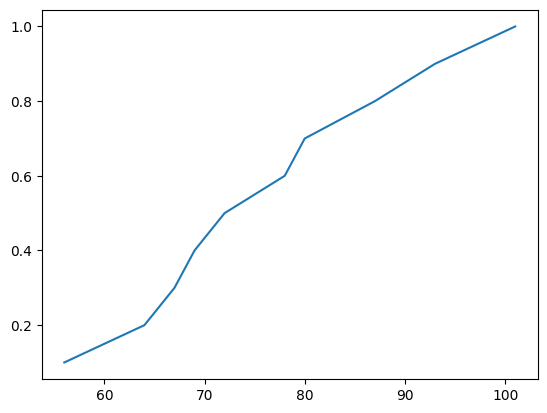

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
X = np.array([56,101,78,67,93,87,64,72,80,69])
mu = np.mean(X)

#estimate the ecdf 
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

xs,ys = ecdf(X)
plt.plot(xs,ys)



[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


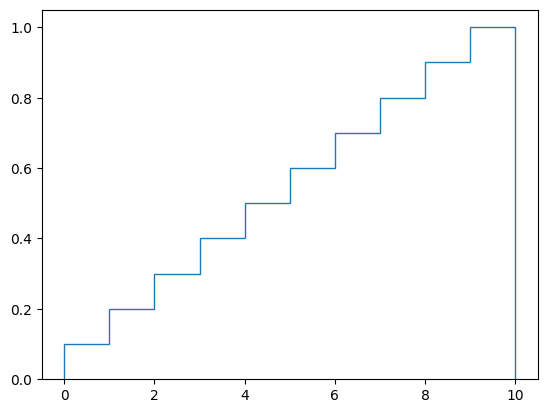

In [10]:
print(ys)
plt.stairs(ys)

Now make a bootstrap:

Best estimate:  0.7591600000000001
Variance of estimate:  0.00018669440000000032


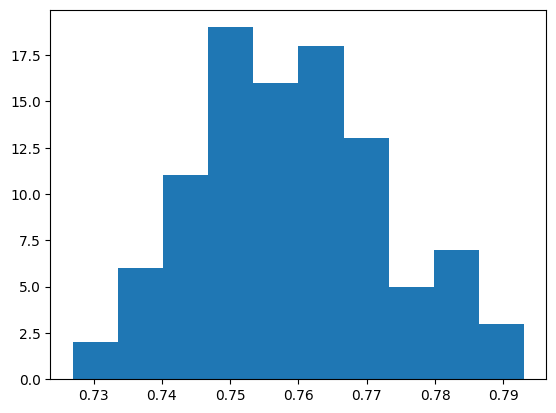

In [36]:
def draw_bootstrap_sample(xs,ys,nsamples):
    samples = []
    for i in range(nsamples):
        U = np.random.uniform()
        for j in range(len(ys)):
            #print(f"Comparing {U} to {ys[j]}")
            if(j==0):
                if(U<ys[0]):
                    samples.append(xs[0])
            else:
                if(ys[j-1]<=U<ys[j]):
                    samples.append(xs[j])
    return np.array(samples)


def bootstrap_estimate_p(xs,ys,mu,a,b,nsamples,nexperiments):
    total = 0
    success = 0
    for i in range(nexperiments):
        sample = draw_bootstrap_sample(xs,ys,nsamples)
        estimator = np.mean(sample)-mu
        #print(estimator)
        if(a<estimator<b):
            success += 1
        else:
            pass
        total += 1 

    return success/total

#conduct 100 experiments of 10x100 bootstraps
p = []
for j in range(100):
    p.append(bootstrap_estimate_p(xs,ys,mu,-5,5,len(X),1000))
    
plt.hist(p)
print("Best estimate: ",np.mean(p))
print("Variance of estimate: ",np.var(p))



We see that the measured values of p are approximately normally distributed, and the best estimate is 0.76.

![alt text](exc15.png "Title")

Best estimator of variance using sample variance:  34.47414285714286
Variance of estimate:  39.758015081632685


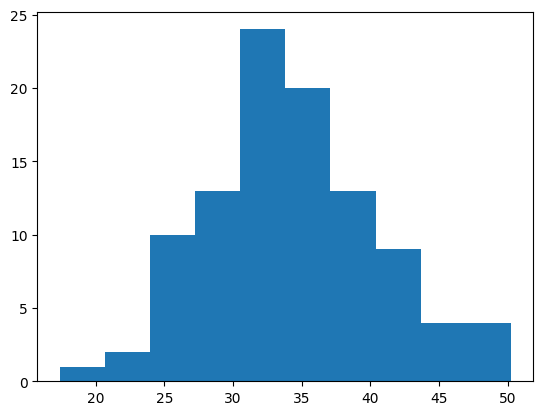

In [40]:
n = 15 
X = np.array([5,4,9,6,21,17,11,20,7,10,21,15,13,16,8])
xs,ys = ecdf(X)
mu = np.mean(X)
def bootstrap_estimate_sample_variance(xs,ys,mu,nsamples,nexperiments):
    total = 0
    success = 0
    for i in range(nexperiments):
        sample = draw_bootstrap_sample(xs,ys,nsamples)
        sample_var = np.sum((sample-mu)**2)/(nsamples-1)
    return sample_var

vars = []
for j in range(100):
    vars.append(bootstrap_estimate_sample_variance(xs,ys,mu,len(X),1000))

plt.hist(vars)
print("Best estimator of variance using sample variance: ",np.mean(vars))
print("Variance of estimate: ",np.var(vars))


We notice that the variance is quite high, and the variance-estimates seem approximately chisq distributed, which seems intuitively correct.

Write a subroutine that takes as input a “data” vector of
observed values, and which outputs the median as well as the
bootstrap estimate of the variance of the median, based on
r = 100 bootstrap replicates. Simulate N = 200 Pareto
distributed random variates with β = 1 and k = 1.05.

In [53]:
import scipy.stats as st
def mean_median_bootstrap(data,r=100):
    xs,ys = ecdf(data)
    nsamples = len(data)
    means = []
    medians = []
    for i in range(r):
        sample = draw_bootstrap_sample(xs,ys,nsamples)
        means.append(np.mean(sample))
        medians.append(np.median(sample))

    mean_estimate = np.mean(means)
    median_estimate = np.mean(medians)
    mean_var = np.var(means)
    median_var = np.var(medians)

    CI_mean = st.norm.interval(0.95,loc=mean_estimate,scale=np.sqrt(mean_var)/np.sqrt(r))
    CI_mean_w = CI_mean[-1]-CI_mean[0]
    print(f"Mean estimate: {mean_estimate}, CI: {CI_mean}, width :{CI_mean_w}")
    CI_median = st.norm.interval(0.95,loc=median_estimate,scale=np.sqrt(median_var)/np.sqrt(r))
    CI_median_w = CI_median[-1]-CI_median[0]
    print(f"Median estimate: {median_estimate}, CI: {CI_median}, width: {CI_median_w}")

    return mean_estimate,mean_var,median_estimate,median_var

beta = 1 
k = 1.05 
N = 200
data = st.pareto.rvs(k,scale=beta,size=N)

_,_,_,_ = mean_median_bootstrap(data,r=100)



#simulated mean to compare
largeSIM = st.pareto.rvs(k,scale=beta,size=1000000)
print(np.mean(largeSIM))
print(np.median(largeSIM))
        


Mean estimate: 10.466880973972367, CI: (9.771444667268732, 11.162317280676003), width :1.3908726134072715
Median estimate: 1.9718083472646644, CI: (1.938568007999813, 2.0050486865295154), width: 0.0664806785297023
13.009209691049703
1.9359384181667696


The mean estimate has a larger confidence interval than the median-estimate. This makes sense, as the mean of the pareto-distribution is heavily influenced by rare (very large) samples, whereas the median is more robust. Thus, even the directly simulated estimated mean should underestimate the mean, which in theory, I think should be 1 (codebox below).
We do see that we underestimate the mean heavily due to rare samples. Theoretical means and medians:

In [54]:
#b = scale 
#alpha = shape 
scale = beta
shape = k
theoreticalmean = scale*shape/(shape-1)
print(theoreticalmean)

theoreticalmedian = scale*np.power(2,1/shape)
print(theoreticalmedian)


20.999999999999982
1.9350635570477832


We see that we estimate the median very nicely but underestimate the mean (which is expected).